Enter the stock ticker symbol (e.g., AAPL, GOOGL):  ^NSEI


                                   Open          High           Low  \
Date                                                                  
2007-09-17 00:00:00+05:30   4518.450195   4549.049805   4482.850098   
2007-09-18 00:00:00+05:30   4494.100098   4551.799805   4481.549805   
2007-09-19 00:00:00+05:30   4550.250000   4739.000000   4550.250000   
2007-09-20 00:00:00+05:30   4734.850098   4760.850098   4721.149902   
2007-09-21 00:00:00+05:30   4752.950195   4855.700195   4733.700195   
...                                 ...           ...           ...   
2024-11-12 00:00:00+05:30  24225.800781  24242.000000  23839.150391   
2024-11-13 00:00:00+05:30  23822.449219  23873.599609  23509.599609   
2024-11-14 00:00:00+05:30  23542.150391  23675.900391  23484.150391   
2024-11-18 00:00:00+05:30  23605.300781  23606.800781  23350.400391   
2024-11-19 00:00:00+05:30  23529.550781  23780.650391  23464.800781   

                                  Close  Volume  Dividends  Stock Splits  
D

Enter start date (YYYY-MM-DD):  2007-09-19
Enter end date (YYYY-MM-DD):  2024-04-04
Enter your initial capital (in INR):  10000



Select Investment Style:
1. Aggressive
2. Moderate
3. Passive


Select a style (1-3):  1
Select a strategy (1: Bollinger Bands, 2: SMA Crossover):  2


/var/folders/zk/42ytt1j578sgmn1rdgh7qr8w0000gn/T/ipykernel_13162/2872546822.py:38: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/zk/42ytt1j578sgmn1rdgh7qr8w0000gn/T/ipykernel_13162/2872546822.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



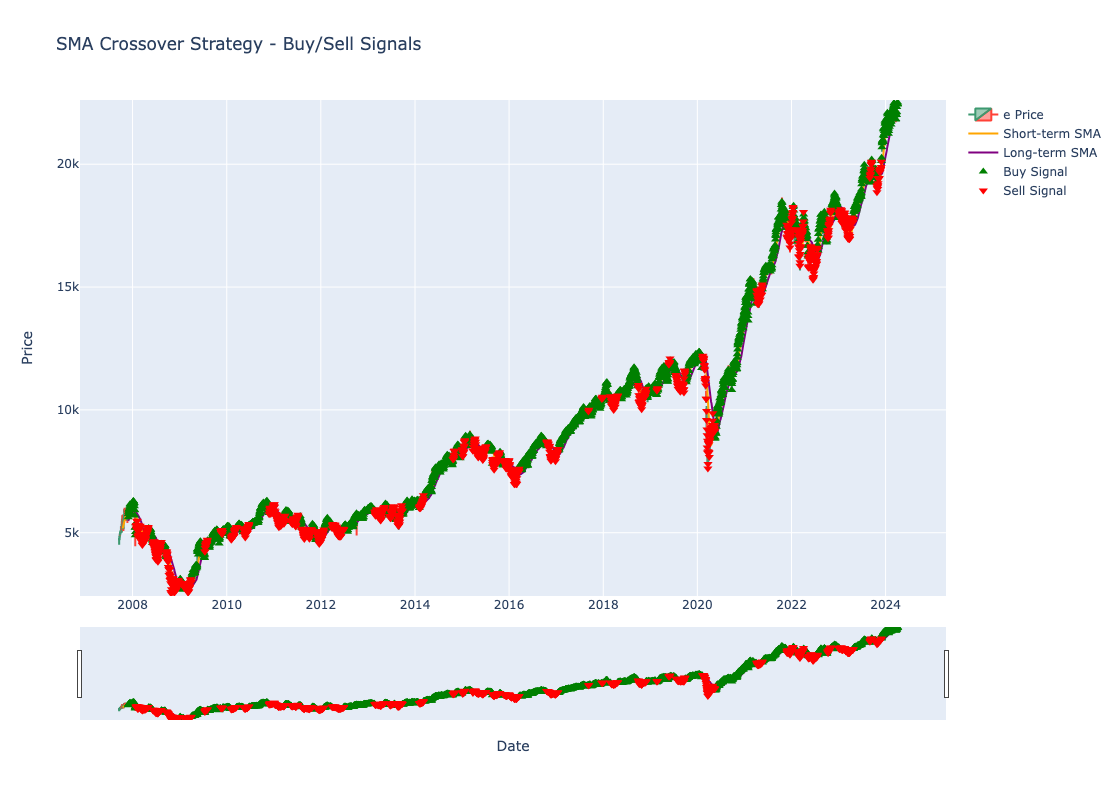

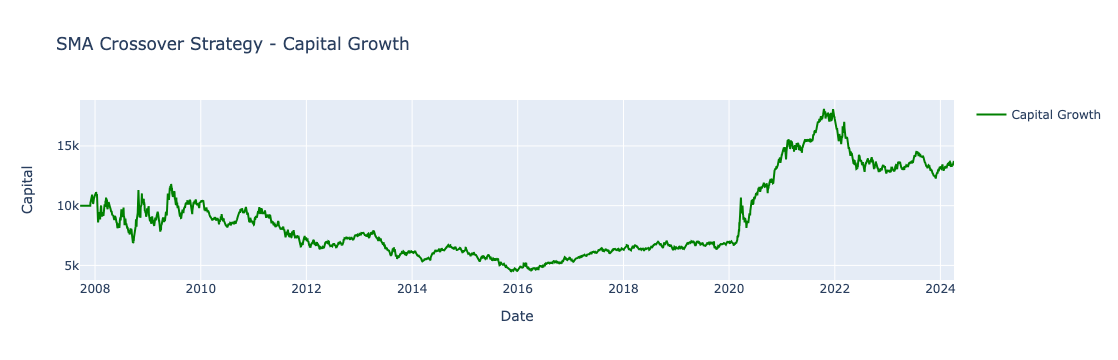


Final Capital: 13677.60 INR
Cumulative ROI: 36.78%
If you had invested 10000.00 at the start of the period, it would now be worth 47576.05.
Your Return on Investment (ROI) is 375.76%.


In [12]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta

def fetch_stock_data(ticker, period):
    stock = yf.Ticker(ticker)
    data = stock.history(period=period)
    print(data)
    return data


# Function to calculate Bollinger Bands
def calculate_bollinger_bands(data, window=20, no_of_std=2):
    data['SMA'] = data['Close'].rolling(window=window).mean()
    data['STD'] = data['Close'].rolling(window=window).std()
    data['Upper Band'] = data['SMA'] + (no_of_std * data['STD'])
    data['Lower Band'] = data['SMA'] - (no_of_std * data['STD'])
    return data

# Function to calculate Simple Moving Averages
def calculate_sma(data, short_window=50, long_window=200):
    data['SMA_Short'] = data['Close'].rolling(window=short_window).mean()
    data['SMA_Long'] = data['Close'].rolling(window=long_window).mean()
    return data

# Strategy 1: Bollinger Bands Strategy
def apply_bollinger_strategy(data):
    data['Signal'] = 0
    data['Signal'][data['Close'] < data['Lower Band']] = 1  # Buy signal
    data['Signal'][data['Close'] > data['Upper Band']] = -1 # Sell signal
    return data

# Strategy 2: SMA Crossover Strategy
def apply_sma_strategy(data):
    data['Signal'] = 0
    data['Signal'][data['SMA_Short'] > data['SMA_Long']] = 1   # Buy signal
    data['Signal'][data['SMA_Short'] < data['SMA_Long']] = -1  # Sell signal
    return data

# Function to adjust strategy parameters based on investment style
def adjust_strategy_parameters(style):
    if style == 'Aggressive':
        return {'bollinger_window': 10, 'bollinger_std': 1.5, 'sma_short': 20, 'sma_long': 50}
    elif style == 'Moderate':
        return {'bollinger_window': 20, 'bollinger_std': 2, 'sma_short': 50, 'sma_long': 200}
    elif style == 'Passive':
        return {'bollinger_window': 30, 'bollinger_std': 2.5, 'sma_short': 100, 'sma_long': 300}
    return {'bollinger_window': 20, 'bollinger_std': 2, 'sma_short': 50, 'sma_long': 200}

# Function to create interactive Plotly visualization for buy/sell signals and capital growth
def visualize_interactive(data, strategy_name, initial_capital, target_currency):
    # Calculate log returns
    data['Returns'] = np.log(data['Close'] / data['Close'].shift(1))
    
    # Shift the Signal to indicate trades made at the close of the previous day
    data['Position'] = data['Signal'].shift(1).fillna(0)
    
    # Calculate strategy returns based on positions
    data['Strategy_Returns'] = data['Position'] * data['Returns']
    
    # Calculate cumulative returns
    data['Cumulative_Strategy_Returns'] = (data['Strategy_Returns'] + 1).cumprod()
    
    # Calculate capital over time based on cumulative strategy returns
    data['Capital'] = initial_capital * data['Cumulative_Strategy_Returns']
    final_capital = data['Capital'].iloc[-1]
    
    # Calculate cumulative ROI
    cumulative_roi = (data['Capital'].iloc[-1] - initial_capital) / initial_capital * 100

    # Check for negative capital growth and print debugging information
    if data['Capital'].min() < 0:
        print("\nWarning: Negative capital detected. Check signal logic and returns calculation.")
        print(data[['Close', 'Signal', 'Position', 'Returns', 'Strategy_Returns', 'Capital']].tail(10))

    # Plot 1: Buy/Sell Signals
    fig1 = go.Figure()

    # Plot Close Price
    fig1.add_trace(go.Candlestick(
        x=data.index,
        open=data['Open'],
        high=data['High'],
        low=data['Low'],
        close=data['Close'],
        name='e Price'
    ))

    if strategy_name == 'Bollinger Bands':
        fig1.add_trace(go.Scatter(x=data.index, y=data['Upper Band'], mode='lines', name='Upper Band', line=dict(dash='dash', color='red')))
        fig1.add_trace(go.Scatter(x=data.index, y=data['Lower Band'], mode='lines', name='Lower Band', line=dict(dash='dash', color='green')))
    
    elif strategy_name == 'SMA Crossover':
        fig1.add_trace(go.Scatter(x=data.index, y=data['SMA_Short'], mode='lines', name='Short-term SMA', line=dict(color='orange')))
        fig1.add_trace(go.Scatter(x=data.index, y=data['SMA_Long'], mode='lines', name='Long-term SMA', line=dict(color='purple')))

    # Add Buy and Sell signals
    fig1.add_trace(go.Scatter(x=data[data['Signal'] == 1].index, y=data[data['Signal'] == 1]['Close'], mode='markers', name='Buy Signal', marker=dict(symbol='triangle-up', color='green', size=8)))
    fig1.add_trace(go.Scatter(x=data[data['Signal'] == -1].index, y=data[data['Signal'] == -1]['Close'], mode='markers', name='Sell Signal', marker=dict(symbol='triangle-down', color='red', size=8)))

    #fig1.update_layout(title=f'{strategy_name} Strategy - Buy/Sell Signals', xaxis_title='Date', yaxis_title='Price', showlegend=True)
    fig1.update_layout(title=f'{strategy_name} Strategy - Buy/Sell Signals', xaxis_title='Date', yaxis_title='Price', showlegend=True,height=800,   width=1000,yaxis=dict(
            range=[data['Close'].min() - 100, data['Close'].max() + 100] ))
    fig1.show()

    # Plot 2: Capital Growth
    fig2 = go.Figure()
    fig2.add_trace(go.Scatter(x=data.index, y=data['Capital'], mode='lines', name='Capital Growth', line=dict(color='green')))
    fig2.update_layout(title=f'{strategy_name} Strategy - Capital Growth', xaxis_title='Date', yaxis_title='Capital', showlegend=True)
    fig2.show()

    # Display Final Capital and ROI
    print(f"\nFinal Capital: {final_capital:.2f} {target_currency}")
    print(f"Cumulative ROI: {cumulative_roi:.2f}%")

def calculate_investment_growth(data, amount):
    """
    Calculate how much the investment would have grown and the ROI.
    :param data: DataFrame with stock data
    :param amount: Investment amount
    :return: Final value of the investment, ROI
    """
    start_price = data['Close'].iloc[0]
    end_price = data['Close'].iloc[-1]
    growth = (end_price / start_price) * amount
    roi = ((growth - amount) / amount) * 100  # ROI in percentage
    return growth, roi

# Main function to load data and apply strategies
def main():
    ticker = input("Enter the stock ticker symbol (e.g., AAPL, GOOGL): ").upper()
    period = "max"

    # Fetch stock data
    try:
        data = fetch_stock_data(ticker, period)
        if data.empty:
            print("No data available for the selected stock and time period.")
            return
    except Exception as e:
        print(f"Error fetching data: {e}")
        return
    
    # Example usage

    
    #
    # Select date range
    start_date = input("Enter start date (YYYY-MM-DD): ")
    end_date = input("Enter end date (YYYY-MM-DD): ")
    data = data[start_date:end_date]

    # Get initial capital
    capital_inr = float(input("Enter your initial capital (in INR): "))
    # indices = {'India': 'INR', 'USA': 'USD', 'Japan': 'JPY'}
    # index_choice = 1 #int(input("Select a country (1: India, 2: USA, 3: Japan): "))
    target_currency = 'INR'
    capital_converted = capital_inr

    # Select investment style
    styles = ['Aggressive', 'Moderate', 'Passive']
    print("\nSelect Investment Style:")
    for i, style in enumerate(styles):
        print(f"{i+1}. {style}")
    style_choice = int(input("Select a style (1-3): "))
    investment_style = styles[style_choice - 1]
    
    # Adjust parameters based on style
    params = adjust_strategy_parameters(investment_style)

    # Select strategy
    strategies = ['Bollinger Bands', 'SMA Crossover']
    strategy_choice = int(input("Select a strategy (1: Bollinger Bands, 2: SMA Crossover): "))
    strategy_name = strategies[strategy_choice - 1]

    # Apply the selected strategy
    if strategy_name == 'Bollinger Bands':
        data = calculate_bollinger_bands(data, params['bollinger_window'], params['bollinger_std'])
        data = apply_bollinger_strategy(data)
    elif strategy_name == 'SMA Crossover':
        data = calculate_sma(data, params['sma_short'], params['sma_long'])
        data = apply_sma_strategy(data)
    
    # Visualize strategy and ROI with interactive Plotly charts
    visualize_interactive(data, strategy_name, capital_converted, target_currency)

    growth, roi=calculate_investment_growth(data, capital_inr)
    print(f"If you had invested {capital_inr:.2f} at the start of the period, it would now be worth {growth:.2f}.")
    print(f"Your Return on Investment (ROI) is {roi:.2f}%.")

if __name__ == "__main__":
    main()


Enter the stock ticker symbol (e.g., AAPL, GOOGL):  ^NSEI


                                   Open          High           Low  \
Date                                                                  
2007-09-17 00:00:00+05:30   4518.450195   4549.049805   4482.850098   
2007-09-18 00:00:00+05:30   4494.100098   4551.799805   4481.549805   
2007-09-19 00:00:00+05:30   4550.250000   4739.000000   4550.250000   
2007-09-20 00:00:00+05:30   4734.850098   4760.850098   4721.149902   
2007-09-21 00:00:00+05:30   4752.950195   4855.700195   4733.700195   
...                                 ...           ...           ...   
2024-11-12 00:00:00+05:30  24225.800781  24242.000000  23839.150391   
2024-11-13 00:00:00+05:30  23822.449219  23873.599609  23509.599609   
2024-11-14 00:00:00+05:30  23542.150391  23675.900391  23484.150391   
2024-11-18 00:00:00+05:30  23605.300781  23606.800781  23350.400391   
2024-11-19 00:00:00+05:30  23529.550781  23780.650391  23464.800781   

                                  Close  Volume  Dividends  Stock Splits  
D

Enter start date (YYYY-MM-DD):  2007-09-17
Enter end date (YYYY-MM-DD):  2024-11-12
Enter your investment amount (e.g., 1000):  10000



Available Investment Styles:
1. Aggressive
2. Moderate
3. Passive


Enter the styles to compare (e.g., 1,2):  1,2,3



Aggressive Style Results:
Final Investment Value: 79706.26
ROI: 697.06%

Moderate Style Results:
Final Investment Value: 53137.51
ROI: 431.38%

Passive Style Results:
Final Investment Value: 39853.13
ROI: 298.53%


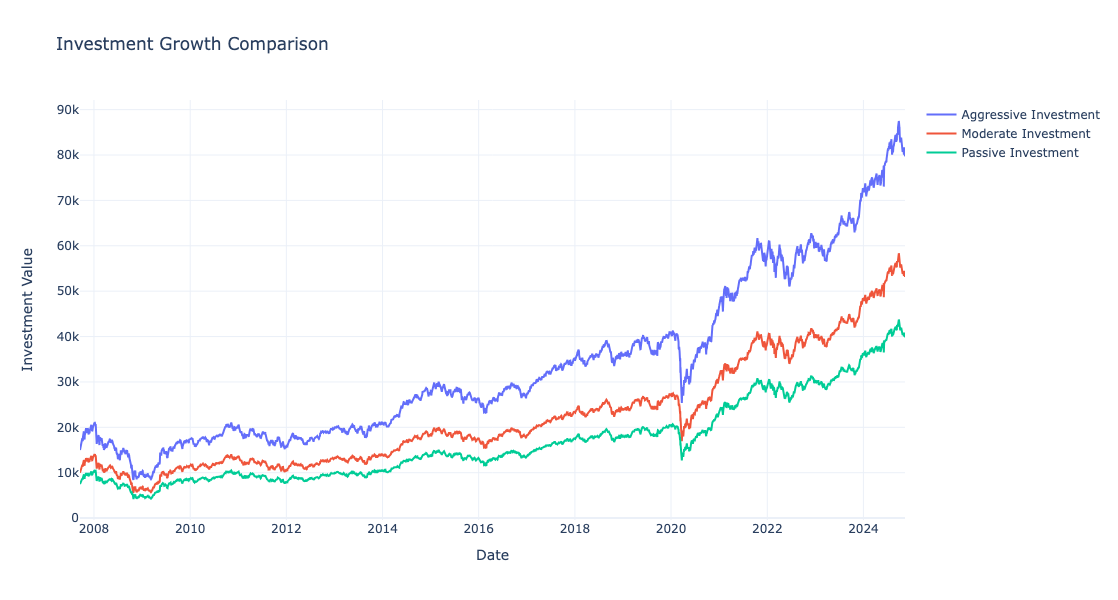

In [27]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta

def fetch_stock_data(ticker, period):
    stock = yf.Ticker(ticker)
    data = stock.history(period=period)
    print(data)
    return data


# Function to calculate Bollinger Bands
def calculate_bollinger_bands(data, window=20, no_of_std=2):
    data['SMA'] = data['Close'].rolling(window=window).mean()
    data['STD'] = data['Close'].rolling(window=window).std()
    data['Upper Band'] = data['SMA'] + (no_of_std * data['STD'])
    data['Lower Band'] = data['SMA'] - (no_of_std * data['STD'])
    return data

# Function to calculate Simple Moving Averages
def calculate_sma(data, short_window=50, long_window=200):
    data['SMA_Short'] = data['Close'].rolling(window=short_window).mean()
    data['SMA_Long'] = data['Close'].rolling(window=long_window).mean()
    return data

# Strategy 1: Bollinger Bands Strategy
def apply_bollinger_strategy(data):
    data['Signal'] = 0
    data['Signal'][data['Close'] < data['Lower Band']] = 1  # Buy signal
    data['Signal'][data['Close'] > data['Upper Band']] = -1 # Sell signal
    return data

# Strategy 2: SMA Crossover Strategy
def apply_sma_strategy(data):
    data['Signal'] = 0
    data['Signal'][data['SMA_Short'] > data['SMA_Long']] = 1   # Buy signal
    data['Signal'][data['SMA_Short'] < data['SMA_Long']] = -1  # Sell signal
    return data

# Function to adjust strategy parameters based on investment style
def adjust_strategy_parameters(style):
    if style == 'Aggressive':
        return {'bollinger_window': 10, 'bollinger_std': 1.5, 'sma_short': 20, 'sma_long': 50}
    elif style == 'Moderate':
        return {'bollinger_window': 20, 'bollinger_std': 2, 'sma_short': 50, 'sma_long': 200}
    elif style == 'Passive':
        return {'bollinger_window': 30, 'bollinger_std': 2.5, 'sma_short': 100, 'sma_long': 300}
    return {'bollinger_window': 20, 'bollinger_std': 2, 'sma_short': 50, 'sma_long': 200}

# Function to create interactive Plotly visualization for buy/sell signals and capital growth
def visualize_interactive(data, strategy_name, initial_capital, target_currency='INR'):
    # Calculate log returns
    data['Returns'] = np.log(data['Close'] / data['Close'].shift(1))
    
    # Shift the Signal to indicate trades made at the close of the previous day
    data['Position'] = data['Signal'].shift(1).fillna(0)
    
    # Calculate strategy returns based on positions
    data['Strategy_Returns'] = data['Position'] * data['Returns']
    
    # Calculate cumulative returns
    data['Cumulative_Strategy_Returns'] = (data['Strategy_Returns'] + 1).cumprod()
    
    # Calculate capital over time based on cumulative strategy returns
    data['Capital'] = initial_capital * data['Cumulative_Strategy_Returns']
    final_capital = data['Capital'].iloc[-1]
    
    # Calculate cumulative ROI
    cumulative_roi = (data['Capital'].iloc[-1] - initial_capital) / initial_capital * 100

    # Check for negative capital growth and print debugging information
    if data['Capital'].min() < 0:
        print("\nWarning: Negative capital detected. Check signal logic and returns calculation.")
        print(data[['Close', 'Signal', 'Position', 'Returns', 'Strategy_Returns', 'Capital']].tail(10))

    # Plot 1: Buy/Sell Signals
    fig1 = go.Figure()

    # Plot Close Price
    fig1.add_trace(go.Candlestick(
        x=data.index,
        open=data['Open'],
        high=data['High'],
        low=data['Low'],
        close=data['Close'],
        name='e Price'
    ))

    if strategy_name == 'Bollinger Bands':
        fig1.add_trace(go.Scatter(x=data.index, y=data['Upper Band'], mode='lines', name='Upper Band', line=dict(dash='dash', color='red')))
        fig1.add_trace(go.Scatter(x=data.index, y=data['Lower Band'], mode='lines', name='Lower Band', line=dict(dash='dash', color='green')))
    
    elif strategy_name == 'SMA Crossover':
        fig1.add_trace(go.Scatter(x=data.index, y=data['SMA_Short'], mode='lines', name='Short-term SMA', line=dict(color='orange')))
        fig1.add_trace(go.Scatter(x=data.index, y=data['SMA_Long'], mode='lines', name='Long-term SMA', line=dict(color='purple')))

    # Add Buy and Sell signals
    fig1.add_trace(go.Scatter(x=data[data['Signal'] == 1].index, y=data[data['Signal'] == 1]['Close'], mode='markers', name='Buy Signal', marker=dict(symbol='triangle-up', color='green', size=8)))
    fig1.add_trace(go.Scatter(x=data[data['Signal'] == -1].index, y=data[data['Signal'] == -1]['Close'], mode='markers', name='Sell Signal', marker=dict(symbol='triangle-down', color='red', size=8)))

    #fig1.update_layout(title=f'{strategy_name} Strategy - Buy/Sell Signals', xaxis_title='Date', yaxis_title='Price', showlegend=True)
    fig1.update_layout(title=f'{strategy_name} Strategy - Buy/Sell Signals', xaxis_title='Date', yaxis_title='Price', showlegend=True,height=800,   width=1000,yaxis=dict(
            range=[data['Close'].min() - 100, data['Close'].max() + 100] ))
    fig1.show()

    # # Plot 2: Capital Growth
    # fig2 = go.Figure()
    # fig2.add_trace(go.Scatter(x=data.index, y=data['Capital'], mode='lines', name='Capital Growth', line=dict(color='green')))
    # fig2.update_layout(title=f'{strategy_name} Strategy - Capital Growth', xaxis_title='Date', yaxis_title='Capital', showlegend=True)
    # fig2.show()

    # # Display Final Capital and ROI
    # print(f"\nFinal Capital: {final_capital:.2f} {target_currency}")
    # print(f"Cumulative ROI: {cumulative_roi:.2f}%")

def calculate_investment_growth(data, amount, style):
    """
    Calculate the investment growth and ROI based on investment style.
    :param data: DataFrame with stock data
    :param amount: Investment amount
    :param style: Investment style ('Aggressive', 'Moderate', 'Passive')
    :return: DataFrame with investment values over time for each style
    """
    start_price = data['Close'].iloc[0]
    end_price = data['Close'].iloc[-1]

    # Style-based multipliers for risk and reward
    style_multipliers = {
        'Aggressive': 1.5,
        'Moderate': 1.0,
        'Passive': 0.75
    }

    # Ensure a valid style is passed
    if style not in style_multipliers:
        raise ValueError("Invalid investment style. Choose from 'Aggressive', 'Moderate', or 'Passive'.")

    multiplier = style_multipliers[style]
    
    # Adjust the growth for the selected style
    growth = (end_price / start_price) * amount * multiplier
    roi = ((growth - amount) / amount) * 100  # ROI in percentage

    # Calculate value over time
    investment_trend = (data['Close'] / start_price) * amount * multiplier
    data[f'{style} Growth'] = investment_trend

    return data, growth, roi

def plot_investment_comparison(data, styles):
    """
    Plot investment growth for all selected styles.
    :param data: DataFrame with investment trends for each style
    :param styles: List of styles to compare ('Aggressive', 'Moderate', 'Passive')
    """
    fig = go.Figure()

    # Add lines for each investment style
    for style in styles:
        if f'{style} Growth' in data:
            fig.add_trace(go.Scatter(
                x=data.index, y=data[f'{style} Growth'],
                mode='lines', name=f"{style} Investment",
                line=dict(width=2)
            ))

    # Update layout
    fig.update_layout(
        title="Investment Growth Comparison",
        xaxis_title="Date",
        yaxis_title="Investment Value",
        template="plotly_white",
        height=600,
        width=900
    )
    fig.show()


# Main function to load data and apply strategies
def main():
    ticker = input("Enter the stock ticker symbol (e.g., AAPL, GOOGL): ").upper()
    period = "max"

    # Fetch stock data
    try:
        data = fetch_stock_data(ticker, period)
        if data.empty:
            print("No data available for the selected stock and time period.")
            return
    except Exception as e:
        print(f"Error fetching data: {e}")
        return

    # Select date range
    start_date = input("Enter start date (YYYY-MM-DD): ")
    end_date = input("Enter end date (YYYY-MM-DD): ")
    data = data[start_date:end_date]

    # Get investment amount
    amount = float(input("Enter your investment amount (e.g., 1000): "))

    # Select styles to compare
    styles = ['Aggressive', 'Moderate', 'Passive']
    print("\nAvailable Investment Styles:")
    for i, style in enumerate(styles):
        print(f"{i+1}. {style}")
    selected_styles = input("Enter the styles to compare (e.g., 1,2): ").split(',')
    selected_styles = [styles[int(choice) - 1] for choice in selected_styles]

    
    # Apply investment growth calculation for each style
    results = {}
    for style in selected_styles:
        data, growth, roi = calculate_investment_growth(data, amount, style)
        results[style] = (growth, roi)
        print(f"\n{style} Style Results:")
        print(f"Final Investment Value: {growth:.2f}")
        print(f"ROI: {roi:.2f}%")

    # Visualize investment growth comparison
    plot_investment_comparison(data, selected_styles)

if __name__ == "__main__":
    main()


Enter the stock ticker symbol (e.g., AAPL, GOOGL):  ^NSEI


                                   Open          High           Low  \
Date                                                                  
2007-09-17 00:00:00+05:30   4518.450195   4549.049805   4482.850098   
2007-09-18 00:00:00+05:30   4494.100098   4551.799805   4481.549805   
2007-09-19 00:00:00+05:30   4550.250000   4739.000000   4550.250000   
2007-09-20 00:00:00+05:30   4734.850098   4760.850098   4721.149902   
2007-09-21 00:00:00+05:30   4752.950195   4855.700195   4733.700195   
...                                 ...           ...           ...   
2024-11-12 00:00:00+05:30  24225.800781  24242.000000  23839.150391   
2024-11-13 00:00:00+05:30  23822.449219  23873.599609  23509.599609   
2024-11-14 00:00:00+05:30  23542.150391  23675.900391  23484.150391   
2024-11-18 00:00:00+05:30  23605.300781  23606.800781  23350.400391   
2024-11-19 00:00:00+05:30  23529.550781  23780.650391  23464.800781   

                                  Close  Volume  Dividends  Stock Splits  
D

Enter start date (YYYY-MM-DD):  2010-03-03
Enter end date (YYYY-MM-DD):  2020-03-03



Available Strategies:
1. Bollinger Bands
2. SMA Crossover


Choose a strategy to apply (1 or 2):  1
Select your investment style (Aggressive, Moderate, Passive):  Moderate


/var/folders/zk/42ytt1j578sgmn1rdgh7qr8w0000gn/T/ipykernel_15105/520170798.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/zk/42ytt1j578sgmn1rdgh7qr8w0000gn/T/ipykernel_15105/520170798.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Enter your initial capital for investment (e.g., 1000):  100000


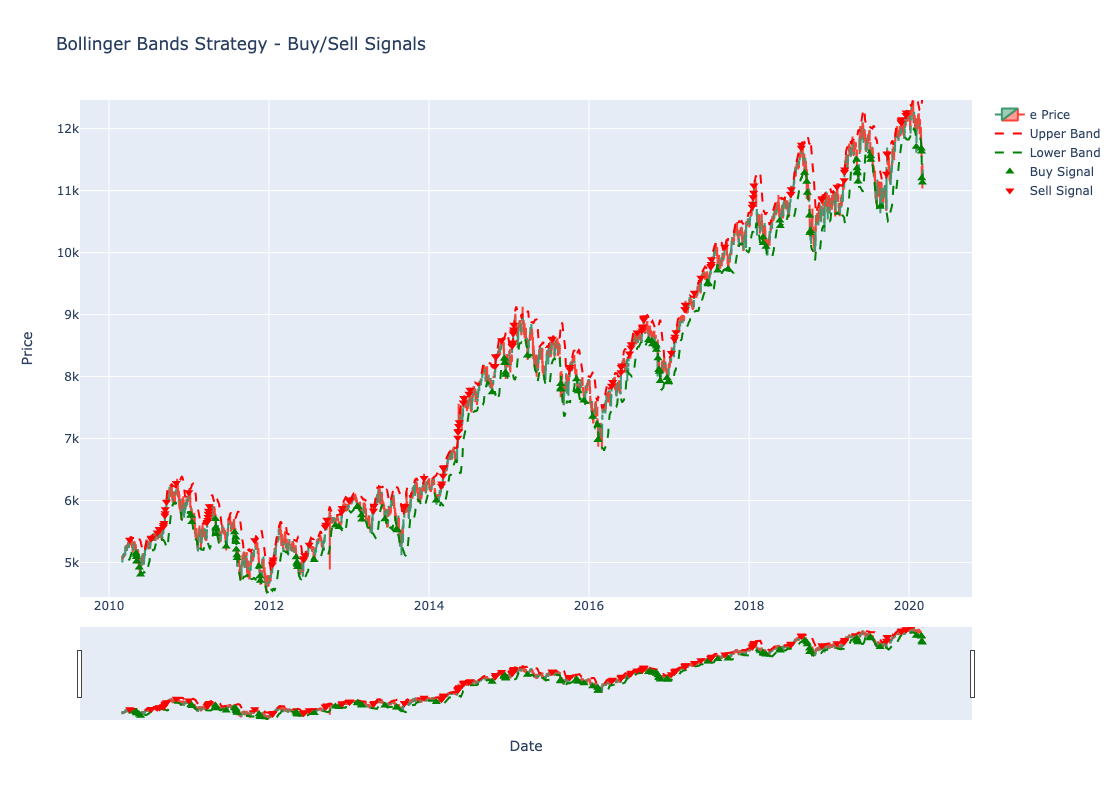


Available Investment Styles:
1. Aggressive
2. Moderate
3. Passive


Enter the styles to compare (e.g., 1,2):  1,2,3



Aggressive Style Results:
Final Investment Value: 333227.52
ROI: 233.23%

Moderate Style Results:
Final Investment Value: 222151.68
ROI: 122.15%

Passive Style Results:
Final Investment Value: 166613.76
ROI: 66.61%


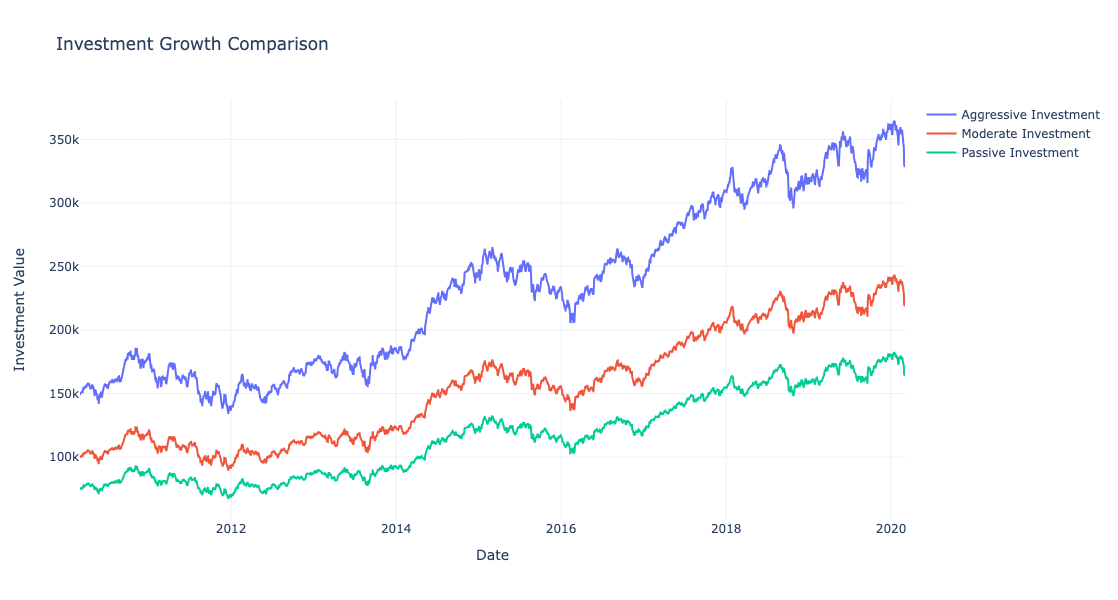

In [2]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta

def fetch_stock_data(ticker, period):
    stock = yf.Ticker(ticker)
    data = stock.history(period=period)
    print(data)
    return data


# Function to calculate Bollinger Bands
def calculate_bollinger_bands(data, window=20, no_of_std=2):
    data['SMA'] = data['Close'].rolling(window=window).mean()
    data['STD'] = data['Close'].rolling(window=window).std()
    data['Upper Band'] = data['SMA'] + (no_of_std * data['STD'])
    data['Lower Band'] = data['SMA'] - (no_of_std * data['STD'])
    return data

# Function to calculate Simple Moving Averages
def calculate_sma(data, short_window=50, long_window=200):
    data['SMA_Short'] = data['Close'].rolling(window=short_window).mean()
    data['SMA_Long'] = data['Close'].rolling(window=long_window).mean()
    return data

# Strategy 1: Bollinger Bands Strategy
def apply_bollinger_strategy(data):
    data['Signal'] = 0
    data['Signal'][data['Close'] < data['Lower Band']] = 1  # Buy signal
    data['Signal'][data['Close'] > data['Upper Band']] = -1 # Sell signal
    return data

# Strategy 2: SMA Crossover Strategy
def apply_sma_strategy(data):
    data['Signal'] = 0
    data['Signal'][data['SMA_Short'] > data['SMA_Long']] = 1   # Buy signal
    data['Signal'][data['SMA_Short'] < data['SMA_Long']] = -1  # Sell signal
    return data

# Function to adjust strategy parameters based on investment style
def adjust_strategy_parameters(style):
    if style == 'Aggressive':
        return {'bollinger_window': 10, 'bollinger_std': 1.5, 'sma_short': 20, 'sma_long': 50}
    elif style == 'Moderate':
        return {'bollinger_window': 20, 'bollinger_std': 2, 'sma_short': 50, 'sma_long': 200}
    elif style == 'Passive':
        return {'bollinger_window': 30, 'bollinger_std': 2.5, 'sma_short': 100, 'sma_long': 300}
    return {'bollinger_window': 20, 'bollinger_std': 2, 'sma_short': 50, 'sma_long': 200}

# Function to create interactive Plotly visualization for buy/sell signals and capital growth
def visualize_interactive(data, strategy_name, initial_capital, target_currency='INR'):
    
    # Plot 1: Buy/Sell Signals
    fig1 = go.Figure()

    # Plot Close Price
    fig1.add_trace(go.Candlestick(
        x=data.index,
        open=data['Open'],
        high=data['High'],
        low=data['Low'],
        close=data['Close'],
        name='e Price'
    ))

    if strategy_name == 'Bollinger Bands':
        fig1.add_trace(go.Scatter(x=data.index, y=data['Upper Band'], mode='lines', name='Upper Band', line=dict(dash='dash', color='red')))
        fig1.add_trace(go.Scatter(x=data.index, y=data['Lower Band'], mode='lines', name='Lower Band', line=dict(dash='dash', color='green')))
    
    elif strategy_name == 'SMA Crossover':
        fig1.add_trace(go.Scatter(x=data.index, y=data['SMA_Short'], mode='lines', name='Short-term SMA', line=dict(color='orange')))
        fig1.add_trace(go.Scatter(x=data.index, y=data['SMA_Long'], mode='lines', name='Long-term SMA', line=dict(color='purple')))

    # Add Buy and Sell signals
    fig1.add_trace(go.Scatter(x=data[data['Signal'] == 1].index, y=data[data['Signal'] == 1]['Close'], mode='markers', name='Buy Signal', marker=dict(symbol='triangle-up', color='green', size=8)))
    fig1.add_trace(go.Scatter(x=data[data['Signal'] == -1].index, y=data[data['Signal'] == -1]['Close'], mode='markers', name='Sell Signal', marker=dict(symbol='triangle-down', color='red', size=8)))

    #fig1.update_layout(title=f'{strategy_name} Strategy - Buy/Sell Signals', xaxis_title='Date', yaxis_title='Price', showlegend=True)
    fig1.update_layout(title=f'{strategy_name} Strategy - Buy/Sell Signals', xaxis_title='Date', yaxis_title='Price', showlegend=True,height=800,   width=1000,yaxis=dict(
            range=[data['Close'].min() - 100, data['Close'].max() + 100] ))
    fig1.show()


def calculate_investment_growth(data, amount, style):
    start_price = data['Close'].iloc[0]
    end_price = data['Close'].iloc[-1]

    # Style-based multipliers for risk and reward
    style_multipliers = {
        'Aggressive': 1.5,
        'Moderate': 1.0,
        'Passive': 0.75
    }

    # Ensure a valid style is passed
    if style not in style_multipliers:
        raise ValueError("Invalid investment style. Choose from 'Aggressive', 'Moderate', or 'Passive'.")

    multiplier = style_multipliers[style]
    
    # Adjust the growth for the selected style
    growth = (end_price / start_price) * amount * multiplier
    roi = ((growth - amount) / amount) * 100  # ROI in percentage

    # Calculate value over time
    investment_trend = (data['Close'] / start_price) * amount * multiplier
    data[f'{style} Growth'] = investment_trend

    return data, growth, roi

def plot_investment_comparison(data, styles):
    # Plot 2 for comparision of return between the chosen style's 
    fig = go.Figure()

    # Add lines for each investment style
    for style in styles:
        if f'{style} Growth' in data:
            fig.add_trace(go.Scatter(
                x=data.index, y=data[f'{style} Growth'],
                mode='lines', name=f"{style} Investment",
                line=dict(width=2)
            ))

    # Update layout
    fig.update_layout(
        title="Investment Growth Comparison",
        xaxis_title="Date",
        yaxis_title="Investment Value",
        template="plotly_white",
        height=600,
        width=900
    )
    fig.show()


# Main function to load data and apply strategies
def main():
    ticker = input("Enter the stock ticker symbol (e.g., AAPL, GOOGL): ").upper()
    period = "max"

    # Fetch stock data
    try:
        data = fetch_stock_data(ticker, period)
        if data.empty:
            print("No data available for the selected stock and time period.")
            return
    except Exception as e:
        print(f"Error fetching data: {e}")
        return

    # Select date range
    start_date = input("Enter start date (YYYY-MM-DD): ")
    end_date = input("Enter end date (YYYY-MM-DD): ")
    data = data[start_date:end_date]

    # Select strategy
    print("\nAvailable Strategies:")
    strategies = ["Bollinger Bands", "SMA Crossover"]
    for i, strategy in enumerate(strategies, 1):
        print(f"{i}. {strategy}")
    strategy_choice = int(input("Choose a strategy to apply (1 or 2): "))

    # Adjust strategy parameters
    style = input("Select your investment style (Aggressive, Moderate, Passive): ")
    params = adjust_strategy_parameters(style)

    # Apply selected strategy
    if strategy_choice == 1:
        data = calculate_bollinger_bands(data, window=params['bollinger_window'], no_of_std=params['bollinger_std'])
        data = apply_bollinger_strategy(data)
        strategy_name = "Bollinger Bands"
    elif strategy_choice == 2:
        data = calculate_sma(data, short_window=params['sma_short'], long_window=params['sma_long'])
        data = apply_sma_strategy(data)
        strategy_name = "SMA Crossover"
    else:
        print("Invalid strategy choice. Exiting.")
        return

    # Visualize the chosen strategy
    initial_capital = float(input("Enter your initial capital for investment (e.g., 1000): "))
    visualize_interactive(data, strategy_name, initial_capital)

    # Select styles to compare investment growth
    styles = ['Aggressive', 'Moderate', 'Passive']
    print("\nAvailable Investment Styles:")
    for i, style in enumerate(styles):
        print(f"{i + 1}. {style}")
    selected_styles = input("Enter the styles to compare (e.g., 1,2): ").split(',')
    selected_styles = [styles[int(choice) - 1] for choice in selected_styles]

    # Apply investment growth calculation for each style
    results = {}
    for style in selected_styles:
        data, growth, roi = calculate_investment_growth(data, initial_capital, style)
        results[style] = (growth, roi)
        print(f"\n{style} Style Results:")
        print(f"Final Investment Value: {growth:.2f}")
        print(f"ROI: {roi:.2f}%")

    # Visualize investment growth comparison
    plot_investment_comparison(data, selected_styles)


if __name__ == "__main__":
    main()